# Apple Quality Check

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score,classification_report

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
df=pd.read_csv('/kaggle/input/apple-quality/apple_quality.csv')

In [3]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


## EDA

### Data Format

1. check null value and delete it

In [4]:
df.isna().sum()

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

In [5]:
df = df.dropna()

2. check duplicates

In [6]:
df.duplicated().sum()

0

3. check data type

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 312.5+ KB


4. conver acidity from object to float

In [8]:
df['Acidity']=df['Acidity'].astype(float)

5. drop id column

In [9]:
df.drop('A_id',axis=1,inplace=True)

6. encoding target values

In [10]:
df['Quality']=df['Quality'].replace({'good': 1,'bad':0})
df['Quality'] = df['Quality'].astype(int)

### Feature Engineering

In [11]:
correlation_matrix = df.corr()

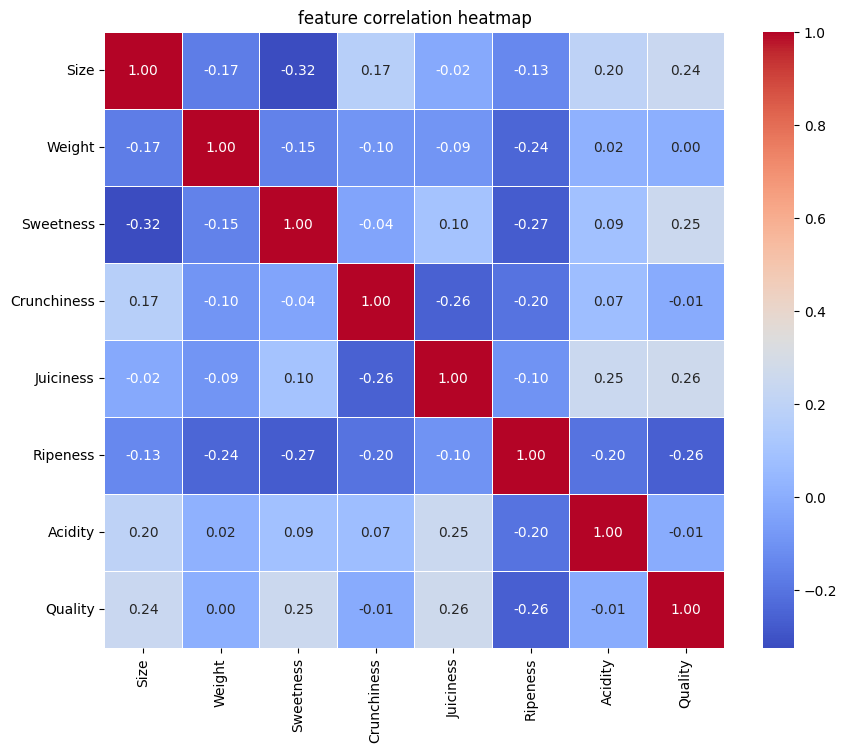

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('feature correlation heatmap')
plt.show()

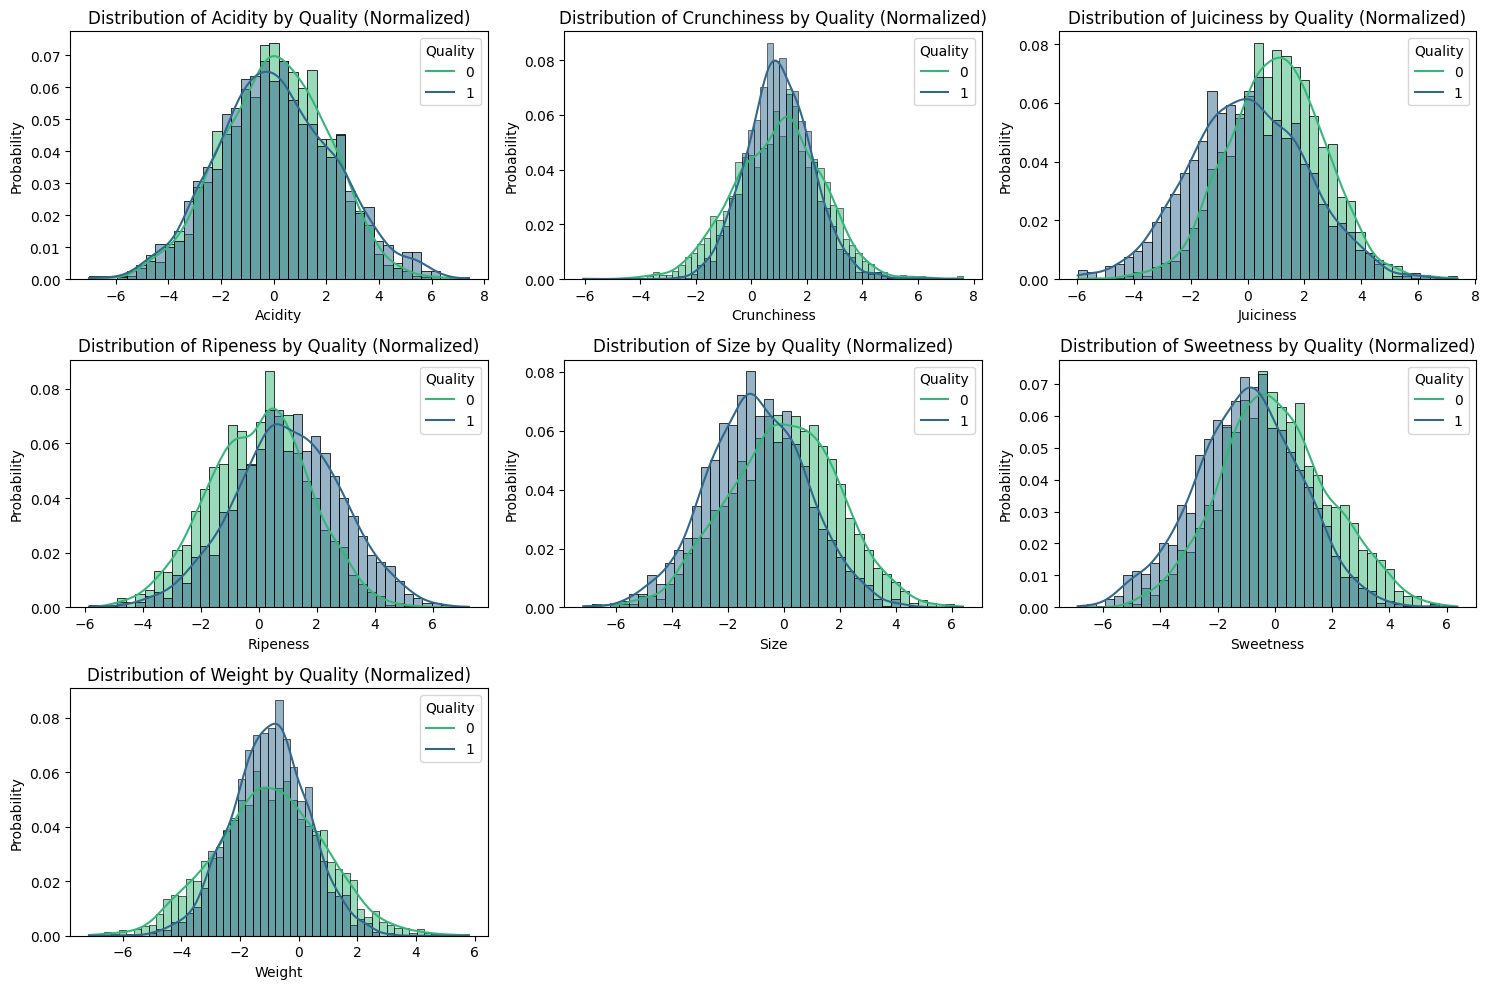

In [13]:
features_to_plot = df.columns.difference(['Quality'])  # Quality以外の特徴量を選択

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i+1)
    sns.histplot(df, x=feature, hue='Quality', stat='probability', common_norm=False, kde=True, palette='viridis')
    plt.title(f'Distribution of {feature} by Quality (Normalized)')
    plt.legend(title='Quality', labels=['0', '1'])

plt.tight_layout()
plt.show()

## Preparation

1. spliting features and target

In [14]:
X=df.drop('Quality',axis=1)
y=df['Quality']

2. split train and test

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Hyper Parameter

In [16]:
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
#         'max_bin': trial.suggest_int('max_bin', 1, 32),
#         'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 100.0),
#         'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
#     }

#     model = CatBoostClassifier(**params, random_state=42, verbose=False)

#     skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     cv_results = cross_val_score(model, X, y, cv=skfold, scoring='accuracy')

#     return cv_results.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [17]:
best_params = {'iterations': 828, 'learning_rate': 0.05189070305523699, 'depth': 8, 'l2_leaf_reg': 0.2393084417420611, 'max_bin': 28, 'bagging_temperature': 18.810537771191647, 'random_strength': 0.05561476460201879, 'min_data_in_leaf': 33, 'subsample': 0.2895330611369089, 'colsample_bylevel': 0.7852216063106355}

## Train Model

In [18]:
best_model = CatBoostClassifier(**best_params, random_state=42, verbose=False)
best_model.fit(X_train, y_train)
y_pred=best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy : ',accuracy)

Accuracy :  0.91375


## Classification Report

In [19]:
print(classification_report(y_test ,y_pred)) 

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       401
           1       0.91      0.91      0.91       399

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

